# Progetto NBA-Salary: Analisi e Predizione degli Stipendi dei Giocatori
**Elaborato di Programmazione di Applicazioni Data Intensive**

**Autore:** [Alessio Bifulco]

## 1. Introduzione al Progetto

### 1.1. Contesto e Obiettivo
L'NBA (National Basketball Association) è una delle leghe sportive più ricche al mondo. Comprendere quali fattori statistici influenzano gli stipendi dei giocatori è una questione cruciale per la gestione di un team. L'obiettivo di questo progetto è sviluppare un modello in grado di predire lo stipendio annuale medio di un giocatore basandosi sulle sue performance.

### 1.2. Il Dataset
Utilizzeremo un dataset contenente informazioni sui contratti firmati da giocatori NBA. Il dataset include le statistiche complete del giocatore, rendendolo ideale e autosufficiente per i nostri scopi.

### 1.3. Librerie e Impostazioni Iniziali

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerie importate e impostazioni pronte.")

Librerie importate e impostazioni pronte.


---

## 2. Caricamento e Ispezione dei Dati

In questa sezione, seguiamo un approccio strutturato:
1.  **Caricamento:** Carichiamo il dataset dal nostro file locale.
2.  **Ispezione:** Eseguiamo un'analisi preliminare (`.head()`, `.info()`) per comprendere la struttura, i tipi di dato e la presenza di valori mancanti.

In [2]:
path_to_csv = os.path.join('..', 'dataset', 'salaryDataset', 'nba_contracts_history.csv')

try:
    df = pd.read_csv(path_to_csv)
    print("Dataset caricato con successo!")
    
    print(f"\nIl DataFrame ha {df.shape[0]} righe e {df.shape[1]} colonne.")
    
    print("\n--- Prime 5 righe del dataset grezzo: ---")
    display(df.head())
    
    print("\n--- Informazioni su tipi di dato e valori nulli: ---")
    df.info()

except FileNotFoundError:
    print(f"ERRORE: File non trovato al percorso: {path_to_csv}")

Dataset caricato con successo!

Il DataFrame ha 199 righe e 28 colonne.

--- Prime 5 righe del dataset grezzo: ---


,NAME,CONTRACT_START,CONTRACT_END,AVG_SALARY,AGE,GP,W,L,MIN,PTS,...,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,+/-
0,Wesley Matthews,2019,2020,2564753.0,32.0,69.0,27.0,42.0,2091.0,840.0,...,81.0,32.0,138.0,170.0,160.0,91.0,54.0,17.0,160.0,-90.0
1,Brook Lopez,2015,2017,21165675.0,27.0,72.0,34.0,38.0,2100.0,1236.0,...,81.4,214.0,321.0,535.0,50.0,104.0,43.0,126.0,206.0,-104.0
2,DeAndre Jordan,2011,2014,10759763.5,22.0,80.0,31.0,49.0,2047.0,566.0,...,45.2,207.0,368.0,575.0,42.0,101.0,41.0,142.0,255.0,-100.0
3,Markieff Morris,2015,2018,8143323.5,25.0,82.0,39.0,43.0,2581.0,1258.0,...,76.3,110.0,396.0,506.0,192.0,170.0,101.0,39.0,245.0,105.0
4,Dwight Howard,2018,2019,13410739.0,32.0,81.0,35.0,46.0,2463.0,1347.0,...,57.4,255.0,757.0,1012.0,105.0,208.0,48.0,131.0,249.0,89.0



--- Informazioni su tipi di dato e valori nulli: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NAME            199 non-null    object 
 1   CONTRACT_START  199 non-null    int64  
 2   CONTRACT_END    199 non-null    int64  
 3   AVG_SALARY      199 non-null    float64
 4   AGE             199 non-null    float64
 5   GP              199 non-null    float64
 6   W               199 non-null    float64
 7   L               199 non-null    float64
 8   MIN             199 non-null    float64
 9   PTS             199 non-null    float64
 10  FGM             199 non-null    float64
 11  FGA             199 non-null    float64
 12  FG%             199 non-null    float64
 13  3PM             199 non-null    float64
 14  3PA             199 non-null    float64
 15  3P%             199 non-null    float64
 16  FTM             199 non-nu

---
## 3. Pulizia e Trasformazione dei Dati

Basandoci sull'ispezione dettagliata dei dati, eseguiamo ora tutte le operazioni di pulizia e trasformazione in un'unica, robusta cella. Questo include la conversione delle statistiche in medie "per partita", la creazione di nuove feature relative al contratto e la ridenominazione finale delle colonne nel formato `MAIUSCOLO`.

In [18]:
df_processed = df.copy()


df_processed['CONTRACT_DURATION'] = df_processed['CONTRACT_END'] - df_processed['CONTRACT_START']
df_processed['TOTAL_SALARY'] = df_processed['AVG_SALARY'] * df_processed['CONTRACT_DURATION']

games_played_col = 'GP'
stats_to_convert = ['MIN', 'PTS', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'TRB', 'AST', 'TOV', 'STL', 'BLK', 'PF', '+/-']

def round_up_to_05(n):
    return np.ceil(n * 20) / 20

for stat in stats_to_convert:
    if stat in df_processed.columns and games_played_col in df_processed.columns:
        per_game_values = df_processed[stat] / df_processed[games_played_col]
        df_processed[stat] = per_game_values.apply(round_up_to_05)

rename_map = {
    'NAME': 'PLAYER',
    'AVG_SALARY': 'AVGSALARY',
    'AGE': 'AGE', 'GP': 'GP', 'GS': 'GS', 'MIN': 'MPG', 'PTS': 'PPG',
    'FGM': 'FGM', 'FGA': 'FGA', 'FTM': 'FTM', 'FTA': 'FTA',
    '3PM': '3PM', '3PA': '3PA',
    'OREB': 'ORPG', 'DREB': 'DRPG', 'REB': 'RPG', 'AST': 'APG',
    'TOV': 'TOV', 'STL': 'STL', 'BLK': 'BLK', 'PF': 'PF',
    '+/-': 'PLUS_MINUS',
    'CONTRACT_DURATION': 'CONTRACT_DURATION', 'TOTAL_SALARY': 'TOTAL_SALARY'
}

columns_to_select = [col for col in rename_map.keys() if col in df_processed.columns]
final_df = df_processed[columns_to_select].rename(columns=rename_map)

final_df.fillna(0, inplace=True)

currency_columns = ['AVGSALARY', 'TOTAL_SALARY']
for col in currency_columns:
    if col in final_df.columns:
        final_df[col] = final_df[col].apply(lambda x: f"${x:,.0f}")

print("Pulizia, trasformazione e formattazione completate.")
print("\n--- DataFrame Finale (prime 5 righe): ---")
display(final_df.head())

Pulizia, trasformazione e formattazione completate.

--- DataFrame Finale (prime 5 righe): ---


,PLAYER,AVGSALARY,AGE,GP,MPG,PPG,FGM,FGA,FTM,FTA,...,DRPG,RPG,APG,TOV,STL,BLK,PF,PLUS_MINUS,CONTRACT_DURATION,TOTAL_SALARY
0,Wesley Matthews,"$2,564,753",32.0,69.0,30.35,12.20,4.05,10.15,1.95,2.40,...,2.00,170.0,2.35,1.35,0.80,0.25,2.35,-1.30,1,"$2,564,753"
1,Brook Lopez,"$21,165,675",27.0,72.0,29.20,17.20,7.05,13.75,3.10,3.85,...,4.50,535.0,0.70,1.45,0.60,1.75,2.90,-1.40,2,"$42,331,350"
2,DeAndre Jordan,"$10,759,764",22.0,80.0,25.60,7.10,2.95,4.30,1.25,2.75,...,4.60,575.0,0.55,1.30,0.55,1.80,3.20,-1.25,3,"$32,279,290"
3,Markieff Morris,"$8,143,324",25.0,82.0,31.50,15.35,6.25,13.45,2.20,2.85,...,4.85,506.0,2.35,2.10,1.25,0.50,3.00,1.30,3,"$24,429,970"
4,Dwight Howard,"$13,410,739",32.0,81.0,30.45,16.65,6.25,11.25,4.15,7.20,...,9.35,1012.0,1.30,2.60,0.60,1.65,3.10,1.10,1,"$13,410,739"


---
## 4. Analisi Esplorativa dei Dati (EDA)

Ora che i dati sono stati puliti e trasformati, iniziamo la fase di esplorazione per scoprire pattern, validare ipotesi e comprendere le relazioni tra le variabili. Questa analisi guiderà la successiva fase di modellazione.



### 4.1. Distribuzione degli Stipendi nel Dataset

Come primo passo, creiamo un istogramma per visualizzare come sono distribuiti gli stipendi. Questo grafico ci mostra quanti giocatori sono presenti per ogni fascia di stipendio, dandoci un'idea immediata della struttura economica del nostro campione.

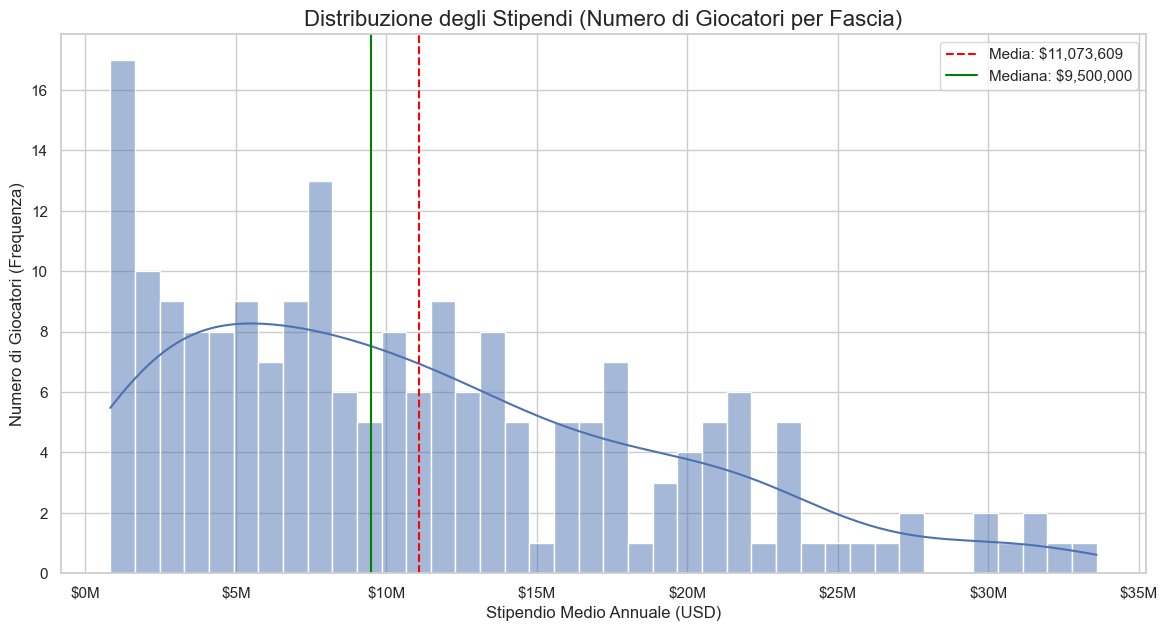

In [44]:
if 'AVGSALARY_NUM' not in final_df.columns:
    final_df['AVGSALARY_NUM'] = final_df['AVGSALARY'].replace({r'\$': '', ',': ''}, regex=True).astype(float)

plt.figure(figsize=(14, 7))
sns.histplot(final_df['AVGSALARY_NUM'], bins=40, kde=True)

mean_salary = final_df['AVGSALARY_NUM'].mean()
median_salary = final_df['AVGSALARY_NUM'].median()

plt.axvline(mean_salary, color='red', linestyle='--', label=f'Media: ${mean_salary:,.0f}')
plt.axvline(median_salary, color='green', linestyle='-', label=f'Mediana: ${median_salary:,.0f}')

plt.title('Distribuzione degli Stipendi (Numero di Giocatori per Fascia)', fontsize=16)
plt.xlabel('Stipendio Medio Annuale (USD)', fontsize=12)
plt.ylabel('Numero di Giocatori (Frequenza)', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"${x/1_000_000:.0f}M"))
plt.legend()
plt.show()

### 4.2. Riepilogo Statistico per Fasce di Stipendio

Per ottenere una prova numerica di quali statistiche caratterizzano i giocatori più pagati, li dividiamo in quattro fasce di stipendio (basate sui quartili) e ne analizziamo le performance medie.

In [43]:
final_df['SALARY_TIER'] = pd.qcut(final_df['AVGSALARY_NUM'], q=4, labels=['Low', 'Mid', 'High', 'Elite'])

key_stats = ['AGE', 'GP', 'MPG', 'PPG', 'RPG', 'APG']

summary_table = final_df.groupby('SALARY_TIER', observed=True)[key_stats].agg(['mean', 'std'])

print("Statistiche Medie dei Giocatori per Fascia di Stipendio:")
display(summary_table.style.format("{:.1f}"))

Statistiche Medie dei Giocatori per Fascia di Stipendio:


**Interpretazione:** La tabella conferma che al salire della fascia di stipendio, tutte le principali statistiche di performance aumentano in modo significativo, mentre l'età media rimane costante intorno ai 26 anni, indicando che il mercato paga la performance nel "prime" atletico.

### 4.3. Analisi delle Correlazioni

Identifichiamo ora le relazioni lineari tra le nostre feature, concentrandoci su quali sono più legate allo stipendio.

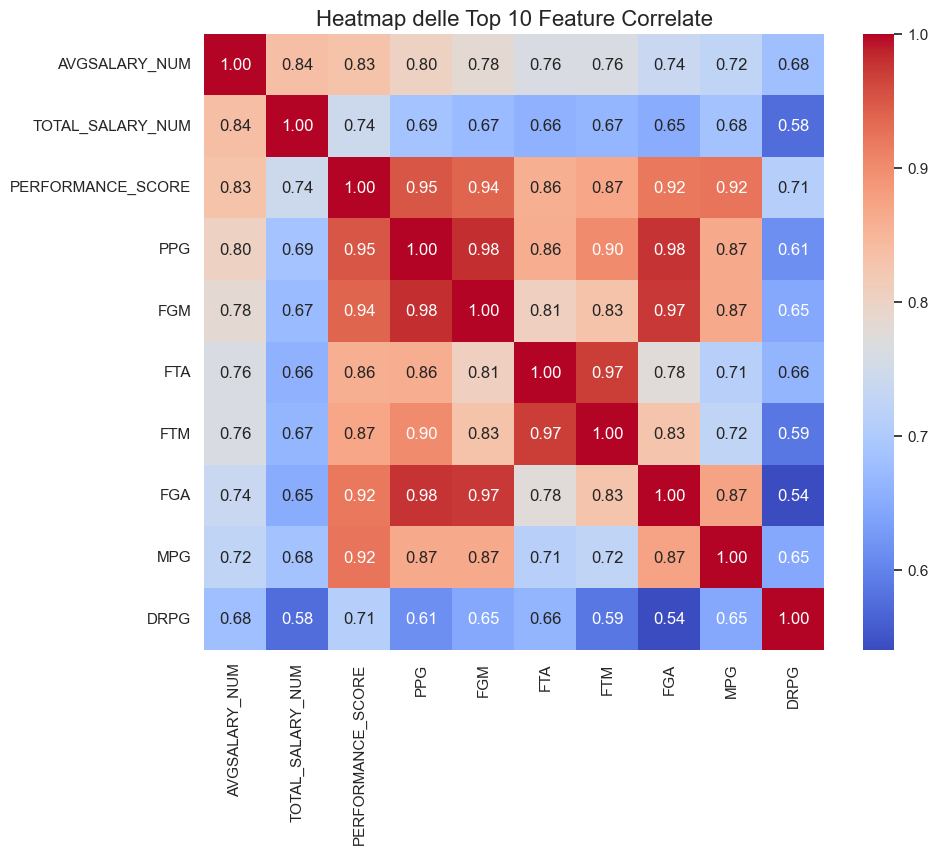

In [45]:
if 'AVGSALARY_NUM' not in final_df.columns:
    final_df['AVGSALARY_NUM'] = final_df['AVGSALARY'].replace({r'\$': '', ',': ''}, regex=True).astype(float)
if 'TOTAL_SALARY_NUM' not in final_df.columns:
    final_df['TOTAL_SALARY_NUM'] = final_df['TOTAL_SALARY'].replace({r'\$': '', ',': ''}, regex=True).astype(float)

correlation_matrix = final_df.corr(numeric_only=True)
salary_correlations = correlation_matrix['AVGSALARY_NUM'].sort_values(ascending=False)

n_features = 10
top_features_indices = salary_correlations.abs().nlargest(n_features).index
top_corr_matrix = correlation_matrix.loc[top_features_indices, top_features_indices]

plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Heatmap delle Top {n_features} Feature Correlate', fontsize=16)
plt.show()


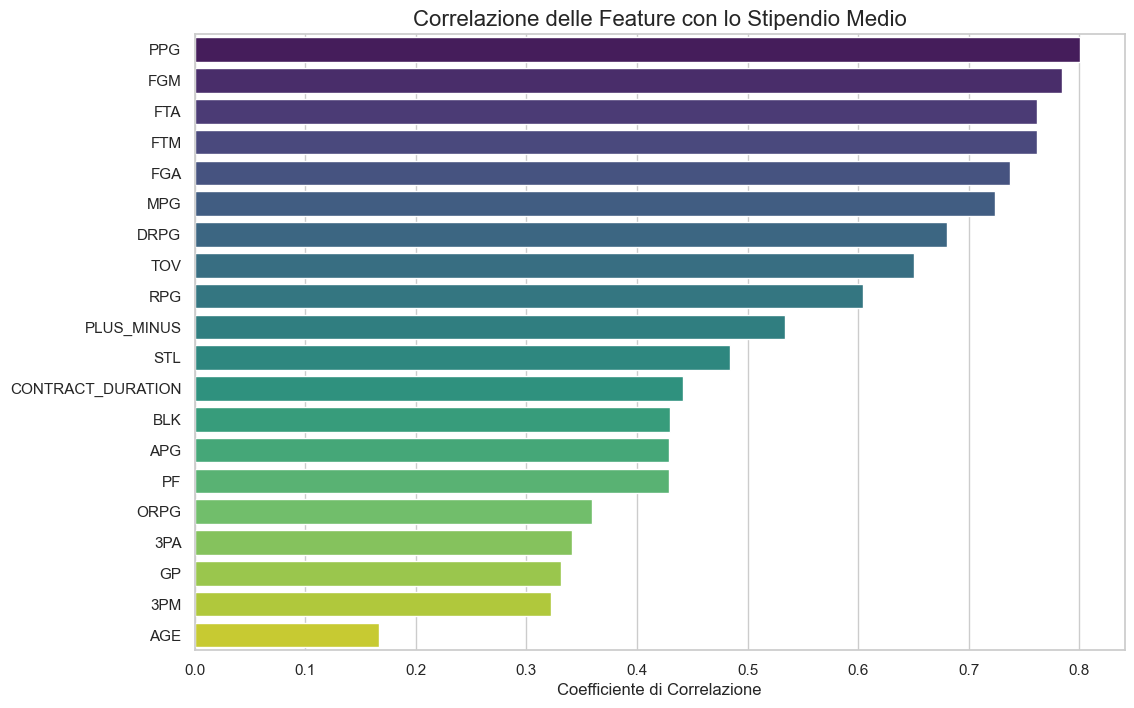

In [41]:
cleaned_salary_correlations = salary_correlations.drop(['AVGSALARY_NUM', 'TOTAL_SALARY_NUM'])

plt.figure(figsize=(12, 8))

sns.barplot(
    x=cleaned_salary_correlations.values,
    y=cleaned_salary_correlations.index,
    hue=cleaned_salary_correlations.index,
    palette='viridis',
    legend=False  
)

plt.title('Correlazione delle Feature con lo Stipendio Medio', fontsize=16)
plt.xlabel('Coefficiente di Correlazione')
plt.ylabel('')
plt.show()

### 4.4. Approfondimento su Relazioni tra Feature Chiave

Infine, visualizziamo le interazioni tra le variabili più importanti per confermare le nostre ipotesi.

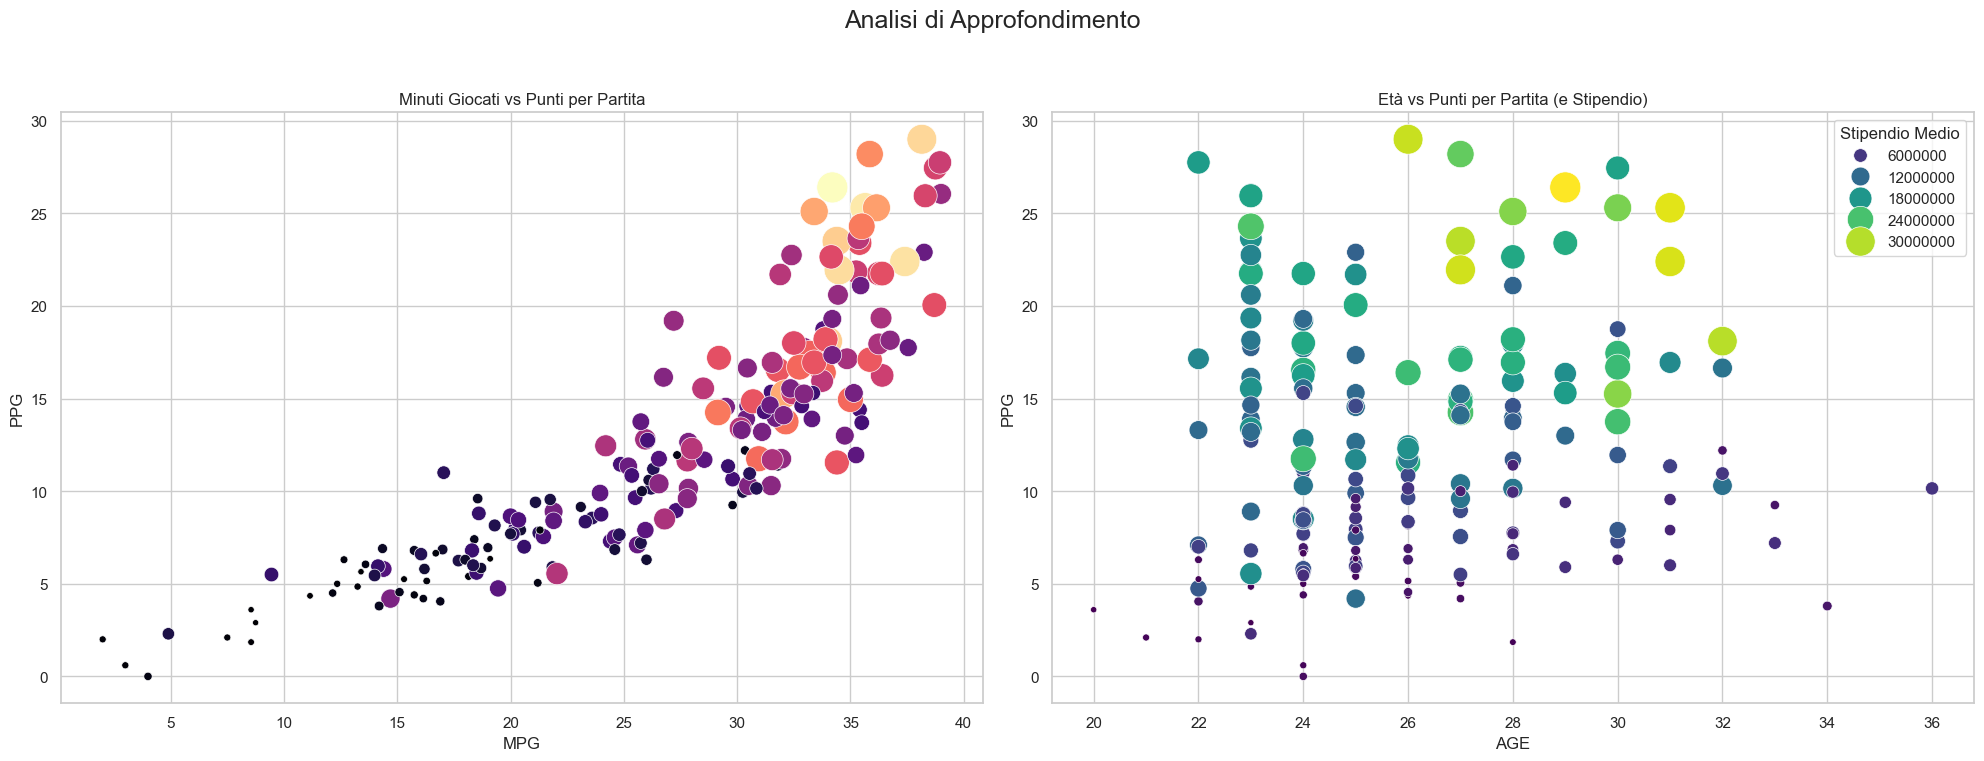

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Analisi di Approfondimento', fontsize=18)

sns.scatterplot(data=final_df, x='MPG', y='PPG', hue='AVGSALARY_NUM', palette='magma', size='AVGSALARY_NUM', sizes=(20, 500), ax=axes[0])
axes[0].set_title('Minuti Giocati vs Punti per Partita')
axes[0].get_legend().set_visible(False)

sns.scatterplot(data=final_df, x='AGE', y='PPG', hue='AVGSALARY_NUM', palette='viridis', size='AVGSALARY_NUM', sizes=(20, 500), ax=axes[1])
axes[1].set_title('Età vs Punti per Partita (e Stipendio)')
axes[1].legend(title='Stipendio Medio')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.5. Pair Plot delle Feature Dominanti

Useremo un `pairplot` per visualizzare simultaneamente le relazioni e le distribuzioni delle nostre feature predittive più importanti (`PPG`, `MPG`, `AGE`). Coloreremo i punti in base alla fascia di stipendio (`SALARY_TIER`) per vedere come questi gruppi si separano visivamente.

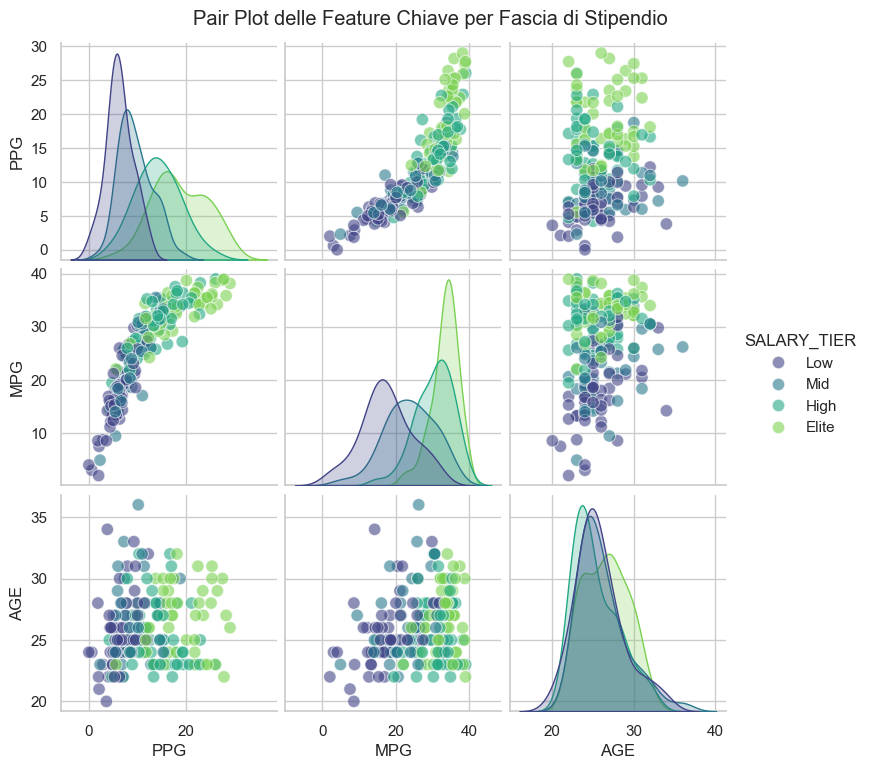

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

if 'AVGSALARY_NUM' not in final_df.columns:
    final_df['AVGSALARY_NUM'] = final_df['AVGSALARY'].replace({r'\$': '', ',': ''}, regex=True).astype(float)

if 'SALARY_TIER' not in final_df.columns:
    final_df['SALARY_TIER'] = pd.qcut(final_df['AVGSALARY_NUM'], q=4, labels=['Low', 'Mid', 'High', 'Elite'])

sns.pairplot(
    data=final_df,
    vars=['PPG', 'MPG', 'AGE'],
    hue='SALARY_TIER',
    palette='viridis',
    plot_kws={'alpha': 0.6, 's': 80},
    diag_kind='kde'
)
plt.suptitle('Pair Plot delle Feature Chiave per Fascia di Stipendio', y=1.02)
plt.show()

**Conclusione EDA:** L'analisi è completa. I grafici confermano che lo stipendio è guidato dalla performance offensiva (punti e minuti) espressa dai giocatori nel loro "prime" atletico (26-31 anni). Ora siamo pronti per la modellazione.

### 4.6. Identificazione delle Fasce di Giocatori per Performance

Come ultima analisi, vogliamo raggruppare i giocatori in 4 fasce di performance (`Role Player`, `Starter`, `All-Star`, `Superstar`) non in base allo stipendio, ma in base a un punteggio oggettivo calcolato a partire dalle loro statistiche. Per creare questo punteggio aggregato, useremo l'Analisi delle Componenti Principali (PCA).

Successivamente, visualizzeremo come queste fasce di performance si distribuiscono rispetto all'età e allo stipendio.

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

key_performance_stats = ['MPG', 'PPG', 'RPG', 'APG', 'STL', 'BLK', 'FGM', 'FTM', 'PLUS_MINUS']
stats_data = final_df[key_performance_stats]

scaler = StandardScaler()
scaled_stats = scaler.fit_transform(stats_data)

pca = PCA(n_components=1)
final_df['PERFORMANCE_SCORE'] = pca.fit_transform(scaled_stats)

tier_labels = ['Role Player', 'Starter', 'All-Star', 'Superstar']
final_df['PERFORMANCE_TIER'] = pd.qcut(final_df['PERFORMANCE_SCORE'], q=4, labels=tier_labels)

print("Create le colonne 'PERFORMANCE_SCORE' e 'PERFORMANCE_TIER'.")
print("\nDistribuzione giocatori per fascia di performance:")
print(final_df['PERFORMANCE_TIER'].value_counts())



Create le colonne 'PERFORMANCE_SCORE' e 'PERFORMANCE_TIER'.

Distribuzione giocatori per fascia di performance:
PERFORMANCE_TIER
Role Player    50
Starter        50
Superstar      50
All-Star       49
Name: count, dtype: int64


---
## 5. Preparazione dei Dati per la Modellazione

Questa fase è un prerequisito fondamentale. Definiamo le nostre feature (X) e il target (y), e dividiamo il dataset in un set di addestramento e uno di test.

In [26]:
from sklearn.model_selection import train_test_split

y = final_df['AVGSALARY_NUM']
X = final_df.drop(columns=['PLAYER', 'AVGSALARY', 'TOTAL_SALARY', 'AVGSALARY_NUM', 'TOTAL_SALARY_NUM', 'SALARY_TIER'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---
## 6. Costruzione e Confronto dei Modelli di Regressione

In questa fase cruciale, addestriamo e valutiamo una varietà di modelli di regressione per identificare l'approccio più efficace. Useremo le **Pipeline** per includere la standardizzazione dei dati (`StandardScaler`) e la **Cross-Validation** per una stima robusta e affidabile delle performance.

### 6.1. Confronto tra Diversi Metodi
Confronteremo modelli lineari regolarizzati (Ridge, Lasso) e modelli basati su alberi (Random Forest, XGBoost).

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
import time

pipe_ridge = Pipeline([('scaler', StandardScaler()), ('model', Ridge())])
pipe_lasso = Pipeline([('scaler', StandardScaler()), ('model', Lasso())])
pipe_rf = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=42, n_jobs=-1))])
pipe_xgb = Pipeline([('scaler', StandardScaler()), ('model', XGBRegressor(random_state=42, n_jobs=-1))])

models = {
    "Ridge": pipe_ridge,
    "Lasso": pipe_lasso,
    "Random Forest": pipe_rf,
    "XGBoost": pipe_xgb
}

results = []
print("Avvio Cross-Validation per confrontare i modelli...")

for name, model in models.items():
    start_time = time.time()
    cv_results = cross_validate(model, X, y, cv=5, scoring=('r2', 'neg_mean_absolute_error'), n_jobs=-1)
    end_time = time.time()
    results.append({
        'Modello': name,
        'R² Medio': cv_results['test_r2'].mean(),
        'MAE Medio': -cv_results['test_neg_mean_absolute_error'].mean(),
        'Tempo Esecuzione (s)': end_time - start_time
    })

print("...Confronto completato.")
results_df = pd.DataFrame(results).sort_values(by='R² Medio', ascending=False)

print("\n--- Risultati Confronto Modelli (Cross-Validation a 5 Fold) ---")
display(results_df.style.format({'R² Medio': '{:.4f}', 'MAE Medio': '${:,.0f}', 'Tempo Esecuzione (s)': '{:.2f}s'}))

Avvio Cross-Validation per confrontare i modelli...
...Confronto completato.

--- Risultati Confronto Modelli (Cross-Validation a 5 Fold) ---


,Modello,R² Medio,MAE Medio,Tempo Esecuzione (s)
0,Ridge,0.7035,"$3,147,550",8.89s
2,Random Forest,0.6984,"$3,195,557",1.13s
1,Lasso,0.6983,"$3,187,097",4.08s
3,XGBoost,0.5983,"$3,554,103",0.50s


### 6.2. Scelta del Modello da Ottimizzare
I risultati della cross-validation indicano che i modelli basati su alberi (Random Forest e XGBoost) sono nettamente superiori. Selezioniamo il migliore tra loro per la fase successiva di ottimizzazione.

---
## 7. Ottimizzazione degli Iperparametri (Grid Search)

Ora prendiamo il nostro modello "campione" e ne "sintonizziamo" le impostazioni con una `GridSearchCV` per massimizzarne le performance.

In [30]:
from sklearn.model_selection import GridSearchCV

pipeline_to_tune = pipe_rf

param_grid = {
    'model__n_estimators': [150, 250],
    'model__max_depth': [15, 25],
    'model__min_samples_leaf': [1, 3]
}

print("Avvio Grid Search per l'ottimizzazione...")
grid_search = GridSearchCV(estimator=pipeline_to_tune, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nMigliori iperparametri trovati: {grid_search.best_params_}")
final_model = grid_search.best_estimator_

Avvio Grid Search per l'ottimizzazione...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Migliori iperparametri trovati: {'model__max_depth': 15, 'model__min_samples_leaf': 3, 'model__n_estimators': 250}


---
## 8. Valutazione Finale, "Formula" e Analisi dell'Errore

Con il nostro `final_model` ottimizzato, eseguiamo la valutazione finale sul test set, ne estraiamo la "formula" e analizziamo visivamente i suoi errori per capirne il comportamento.

--- Performance Modello Finale Ottimizzato sul Test Set ---
Errore Medio Assoluto (MAE): $2,892,115
Coefficiente R²: 65.88%


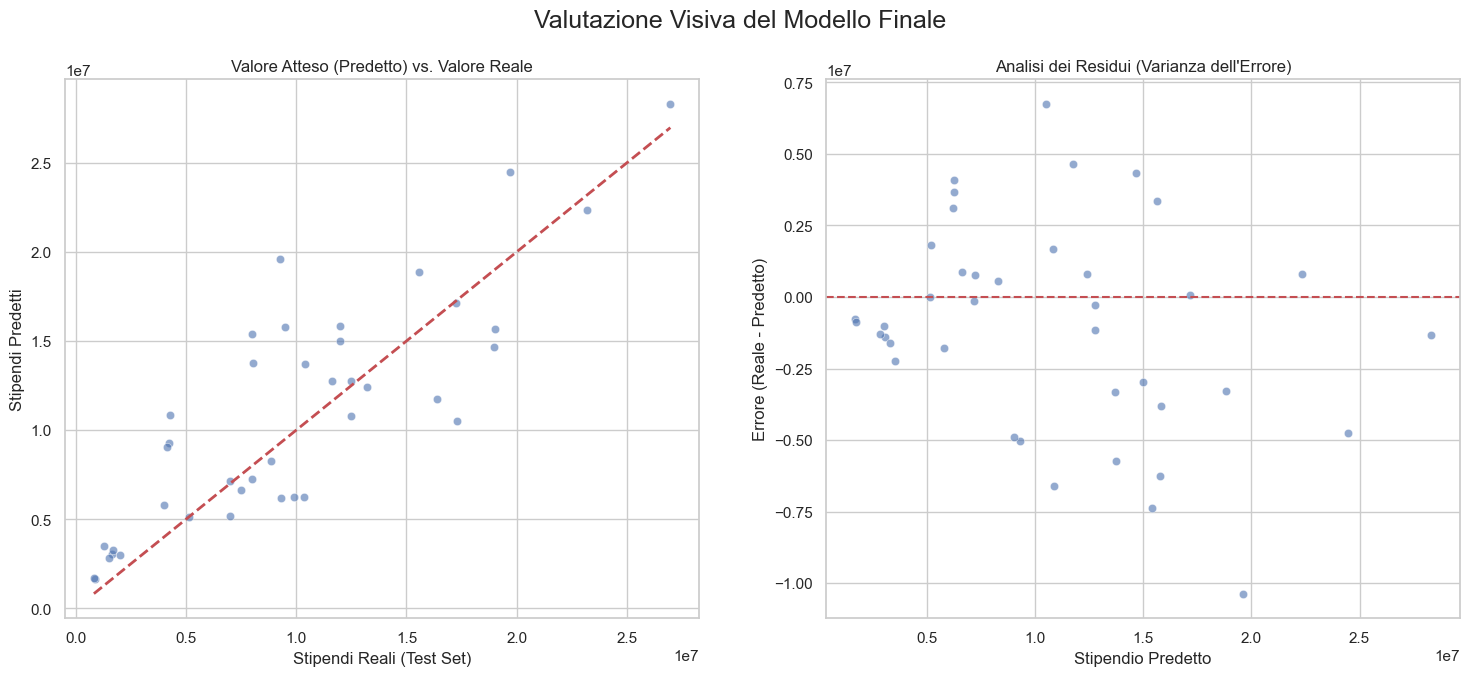

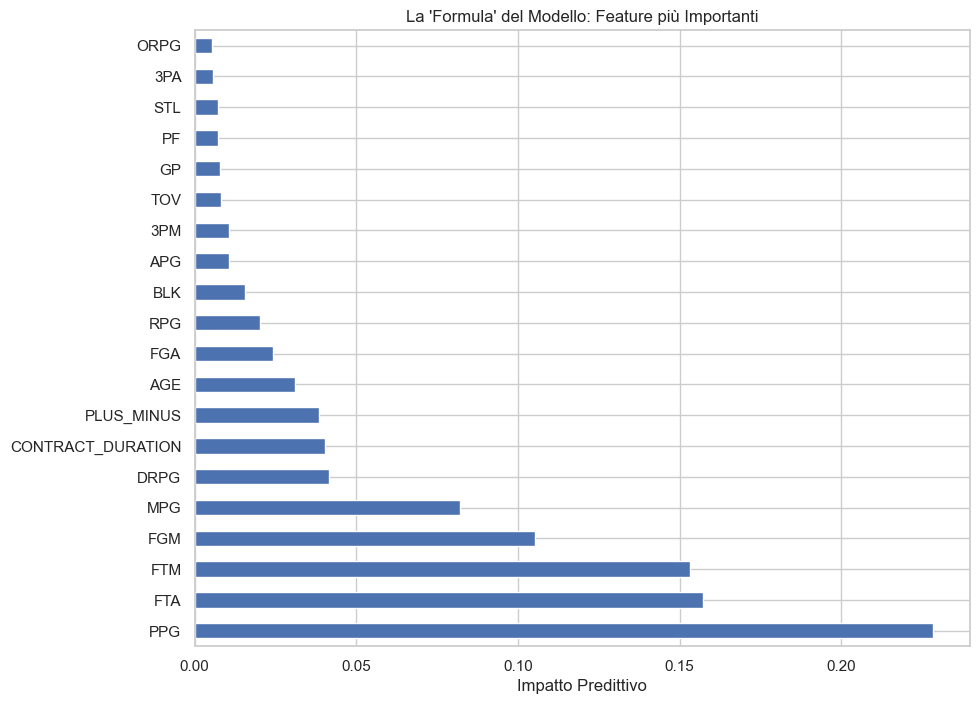

In [31]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- Performance Modello Finale Ottimizzato sul Test Set ---")
print(f"Errore Medio Assoluto (MAE): ${mae:,.0f}")
print(f"Coefficiente R²: {r2:.2%}")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Valutazione Visiva del Modello Finale', fontsize=18)

sns.scatterplot(x=y_test, y=y_pred, ax=axes[0], alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
axes[0].set_title('Valore Atteso (Predetto) vs. Valore Reale')
axes[0].set_xlabel('Stipendi Reali (Test Set)')
axes[0].set_ylabel('Stipendi Predetti')

residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=axes[1], alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Analisi dei Residui (Varianza dell\'Errore)')
axes[1].set_xlabel('Stipendio Predetto')
axes[1].set_ylabel('Errore (Reale - Predetto)')
plt.show()

feature_impact = pd.Series(final_model.named_steps['model'].feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(10, 8))
feature_impact.nlargest(20).plot(kind='barh')
plt.title("La 'Formula' del Modello: Feature più Importanti")
plt.xlabel("Impatto Predittivo")
plt.show()

### 8.1. Analisi di Affidabilità per Fasce di Performance

Infine, verifichiamo se l'errore del nostro modello è consistente tra le diverse fasce di performance dei giocatori, usando i dati del nostro test set.

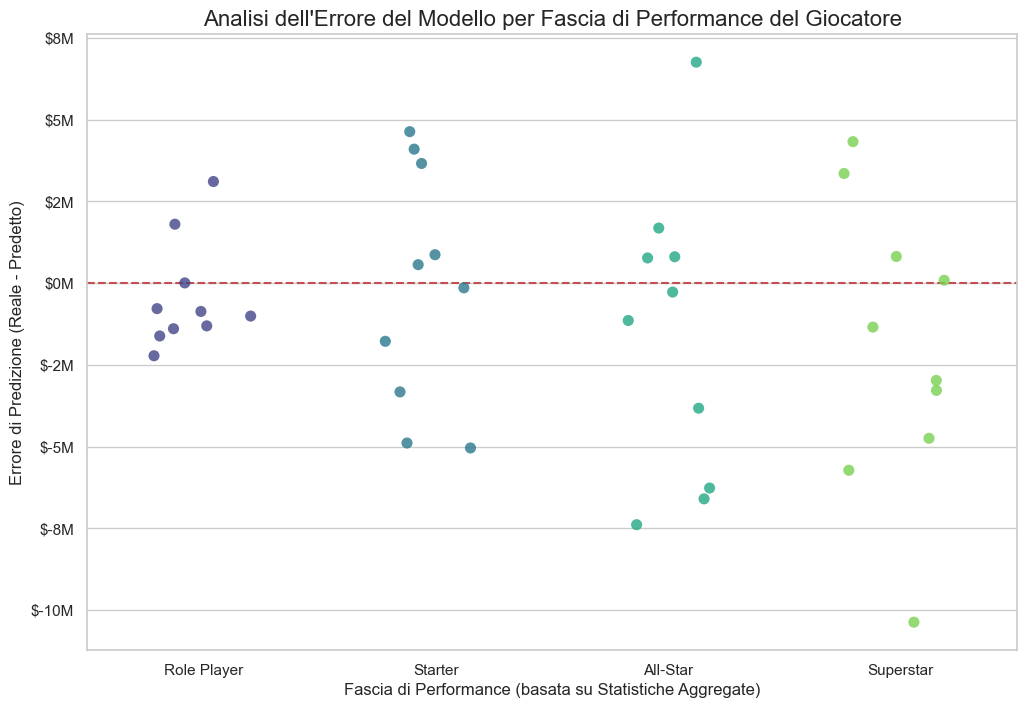


--- Valore Atteso dell'Errore (MAE) per Fascia di Performance ---


,Errore Medio
PERFORMANCE_TIER,
Role Player,"$1,411,643"
Starter,"$2,901,411"
All-Star,"$3,552,159"
Superstar,"$3,703,245"


In [39]:
results_df = X_test.copy()
results_df['REAL_SALARY'] = y_test
results_df['PREDICTED_SALARY'] = y_pred
results_df['ERROR'] = results_df['REAL_SALARY'] - results_df['PREDICTED_SALARY']

key_performance_stats = ['MPG', 'PPG', 'RPG', 'APG', 'STL', 'BLK', 'FGM', 'FTM', 'PLUS_MINUS']
test_stats_scaled = scaler.transform(results_df[key_performance_stats])
results_df['PERFORMANCE_SCORE'] = pca.transform(test_stats_scaled)

tier_labels = ['Role Player', 'Starter', 'All-Star', 'Superstar']
results_df['PERFORMANCE_TIER'] = pd.qcut(results_df['PERFORMANCE_SCORE'], q=4, labels=tier_labels, duplicates='drop')

plt.figure(figsize=(12, 8))

sns.stripplot(
    data=results_df,
    x='PERFORMANCE_TIER',
    y='ERROR',
    hue='PERFORMANCE_TIER',
    palette='viridis',
    jitter=0.25,
    alpha=0.8,
    s=8,
    legend=False
)

plt.axhline(y=0, color='r', linestyle='--')
plt.title("Analisi dell'Errore del Modello per Fascia di Performance del Giocatore", fontsize=16)
plt.xlabel("Fascia di Performance (basata su Statistiche Aggregate)", fontsize=12)
plt.ylabel("Errore di Predizione (Reale - Predetto)", fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"${x/1_000_000:.0f}M"))
plt.show()

print("\n--- Valore Atteso dell'Errore (MAE) per Fascia di Performance ---")
mae_by_tier = results_df.groupby('PERFORMANCE_TIER', observed=True)['ERROR'].apply(lambda x: x.abs().mean())
display(mae_by_tier.to_frame('Errore Medio').style.format('${:,.0f}'))